In [1]:
import pandas as pd
from datetime import datetime

# Sample data based on the given CSV content
data = {
    'InvoiceNo': [536365, 536365, 536365, 536365, 536365, 536365, 536365, 536366, 536366],
    'StockCode': ['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632'],
    'Description': ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER',
                    'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.', 'SET 7 BABUSHKA NESTING BOXES',
                    'GLASS STAR FROSTED T-LIGHT HOLDER', 'HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'],
    'Quantity': [6, 6, 8, 6, 6, 2, 6, 6, 6],
    'InvoiceDate': ['12-01-2010 08:26', '12-01-2010 08:26', '12-01-2010 08:26', '12-01-2010 08:26', '12-01-2010 08:26',
                    '12-01-2010 08:26', '12-01-2010 08:26', '12-01-2010 08:28', '12-01-2010 08:28'],
    'UnitPrice': [2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25, 1.85, 1.85],
    'CustomerID': [17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850, 17850],
    'Country': ['United Kingdom'] * 9
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

# Calculate Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Create a TimeID for aggregation
df['TimeID'] = df['InvoiceDate'].dt.to_period('M')  # Monthly aggregation

# Aggregate data for Enterprise-Level Model
enterprise_level = df.groupby('TimeID').agg({'Revenue': 'sum'}).reset_index()

# Aggregate data for Product-Level Model
product_level = df.groupby(['StockCode', 'TimeID']).agg({'Quantity': 'sum', 'Revenue': 'sum'}).reset_index()

enterprise_level, product_level


(    TimeID  Revenue
 0  2010-01   161.32,
   StockCode   TimeID  Quantity  Revenue
 0     21730  2010-01         6    25.50
 1     22632  2010-01         6    11.10
 2     22633  2010-01         6    11.10
 3     22752  2010-01         2    15.30
 4     71053  2010-01         6    20.34
 5    84029E  2010-01         6    20.34
 6    84029G  2010-01         6    20.34
 7    84406B  2010-01         8    22.00
 8    85123A  2010-01         6    15.30)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# Step 1: Data Preparation (Assuming 'df' is your dataframe)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['TimeID'] = df['InvoiceDate'].dt.to_period('M')  # Monthly aggregation

# Aggregate data for enterprise-level model
enterprise_level = df.groupby('TimeID').agg({'Revenue': 'sum'}).reset_index()
enterprise_level['TimeID'] = pd.to_datetime(enterprise_level['TimeID'].astype(str))
enterprise_level['TimeID_num'] = enterprise_level.index  # Convert TimeID to numerical form for regression

# Step 2: Moving Average
enterprise_level['Revenue_MA'] = enterprise_level['Revenue'].rolling(window=3).mean()  # 3-period moving average

# Step 3: Train-Test Split
X = enterprise_level[['TimeID_num']].values
y = enterprise_level['Revenue'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Step 5: K-Nearest Neighbors Model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Step 6: Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=1, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1)
y_pred_nn = nn_model.predict(X_test)

# Step 7: Evaluate Models
mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
print(f"Logistic Regression MAE: {mae_log}, MSE: {mse_log}")

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN MAE: {mae_knn}, MSE: {mse_knn}")

mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MAE: {mae_nn}, MSE: {mse_nn}")

# Step 8: Plot Results (Optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue'], label='Actual Revenue')
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue_MA'], label='Moving Average', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Revenue Forecasting')
plt.show()


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 448375226368.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 478308663296.0000 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 421972901888.0000 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 496768122880.0000 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 478424825856.0000 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 418870329344.0000 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 496713039872.0000 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 482359672832.0000 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 447040258048.0000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 477668802560.0000
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 473488687104.0000 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 429838139392.0000
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 414478598144.0000
Epoch 14/50
2/2 ━━━━━

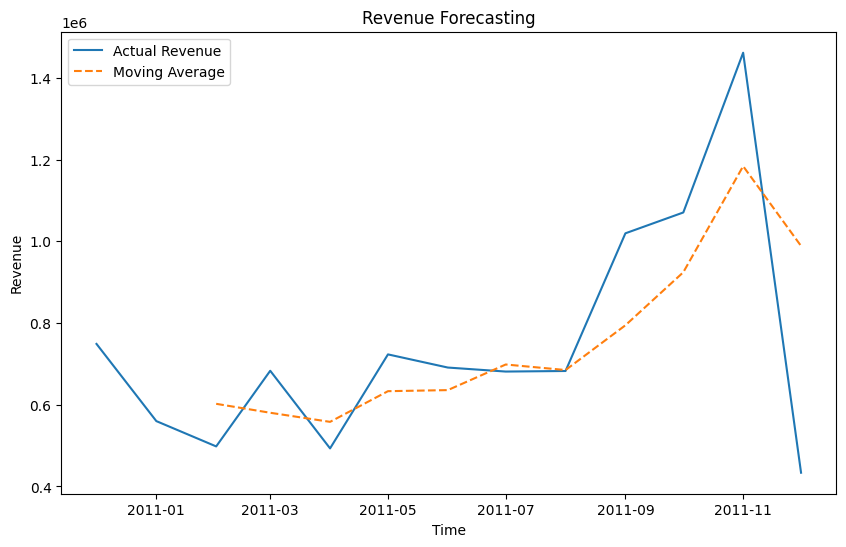

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Step 1: Read the CSV File
file_path = 'OnlineRetail.csv'  # Update with your file path if necessary
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Step 2: Data Preparation
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Step 3: Create TimeID for Aggregation
df['TimeID'] = df['InvoiceDate'].dt.to_period('M')  # Monthly aggregation

# Aggregate data for enterprise-level model
enterprise_level = df.groupby('TimeID').agg({'Revenue': 'sum'}).reset_index()
enterprise_level['TimeID'] = pd.to_datetime(enterprise_level['TimeID'].astype(str))
enterprise_level['TimeID_num'] = enterprise_level.index  # Convert TimeID to numerical form for regression

# Step 4: Moving Average
enterprise_level['Revenue_MA'] = enterprise_level['Revenue'].rolling(window=3).mean()  # 3-period moving average

# Step 5: Train-Test Split
X = enterprise_level[['TimeID_num']].values
y = enterprise_level['Revenue'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Step 7: K-Nearest Neighbors Model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Step 8: Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=1, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1)
y_pred_nn = nn_model.predict(X_test)

# Step 9: Evaluate Models
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"Linear Regression MAE: {mae_lin}, MSE: {mse_lin}")

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN MAE: {mae_knn}, MSE: {mse_knn}")

mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MAE: {mae_nn}, MSE: {mse_nn}")

# Step 10: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue'], label='Actual Revenue')
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue_MA'], label='Moving Average', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Revenue Forecasting')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 467458654208.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 432750952448.0000 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 429358579712.0000 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 422100598784.0000 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 447764758528.0000 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 433790451712.0000 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 418099888128.0000 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 409973653504.0000 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 479146737664.0000 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 429843152896.0000 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 425473998848.0000 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 446722605056.0000 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 432315727872.0000 
Epoch 14/50
2/2 ━━━━━

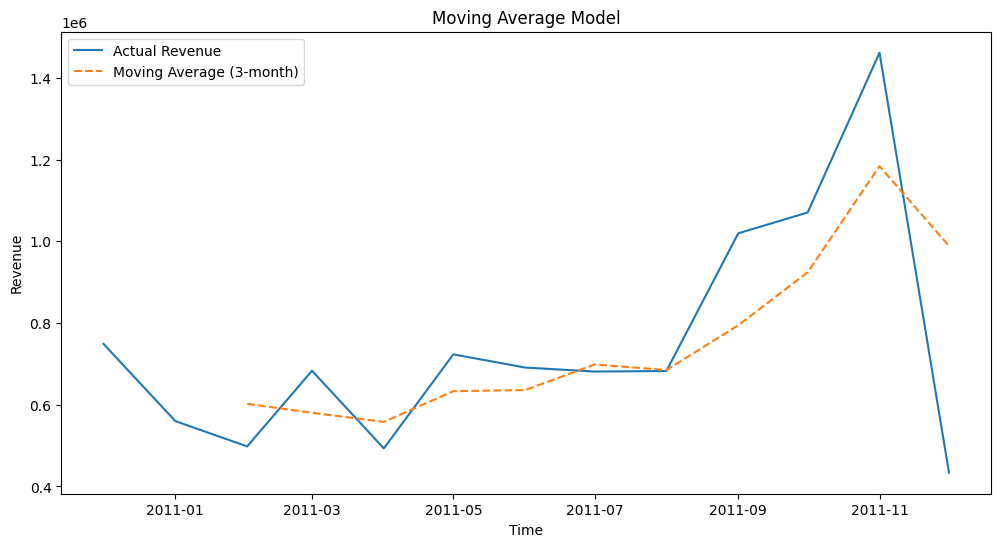

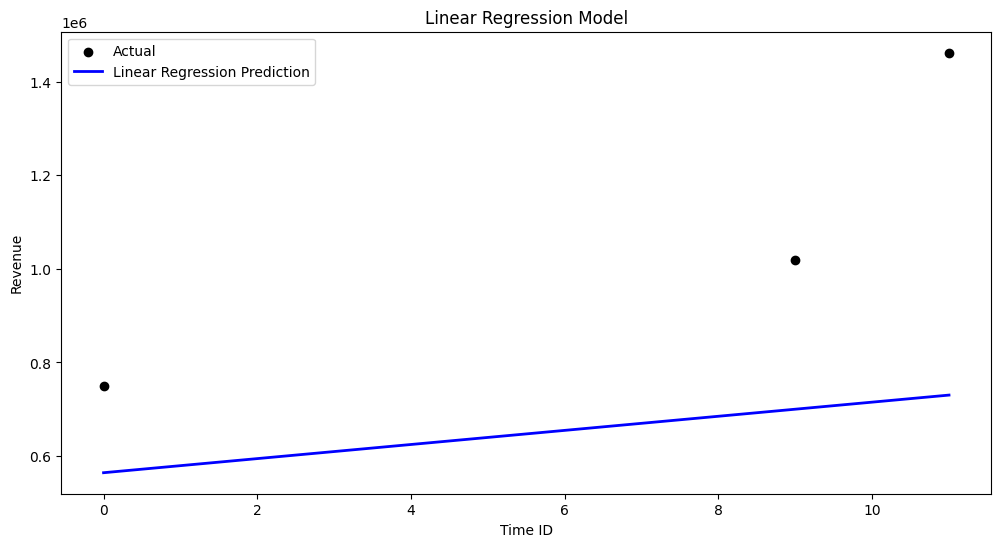

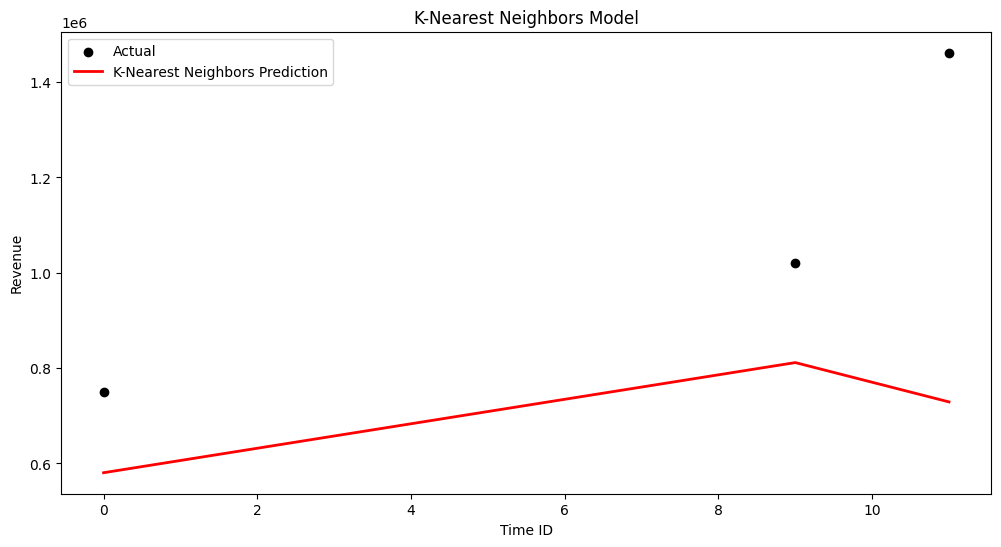

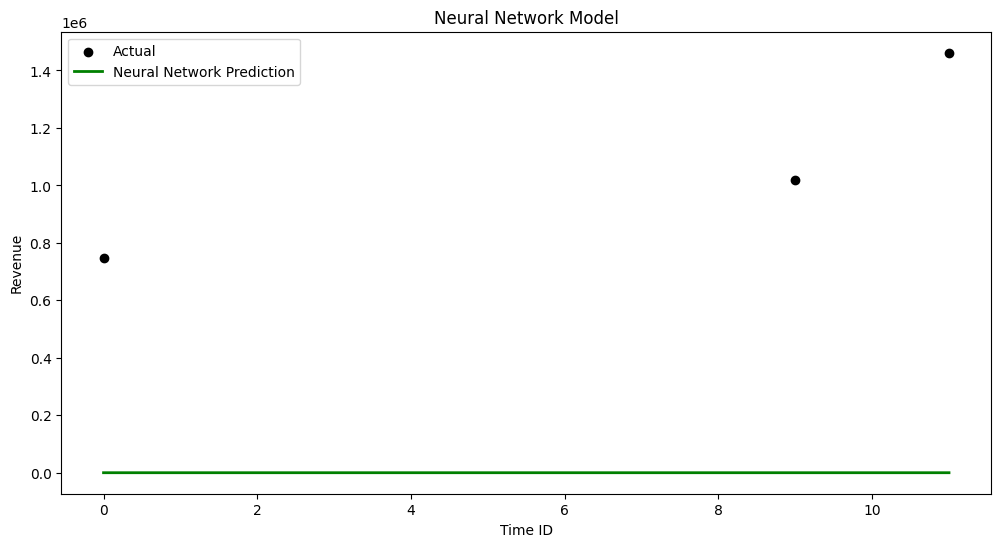

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Step 1: Read the CSV File
file_path = 'OnlineRetail.csv'  # Update with your file path if necessary
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Step 2: Data Preparation
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Step 3: Create TimeID for Aggregation
df['TimeID'] = df['InvoiceDate'].dt.to_period('M')  # Monthly aggregation

# Aggregate data for enterprise-level model
enterprise_level = df.groupby('TimeID').agg({'Revenue': 'sum'}).reset_index()
enterprise_level['TimeID'] = pd.to_datetime(enterprise_level['TimeID'].astype(str))
enterprise_level['TimeID_num'] = enterprise_level.index  # Convert TimeID to numerical form for regression

# Step 4: Moving Average
enterprise_level['Revenue_MA'] = enterprise_level['Revenue'].rolling(window=3).mean()  # 3-period moving average

# Step 5: Train-Test Split
X = enterprise_level[['TimeID_num']].values
y = enterprise_level['Revenue'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Step 7: K-Nearest Neighbors Model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Step 8: Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=1, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1)
y_pred_nn = nn_model.predict(X_test)

# Step 9: Evaluate Models
mae_lin = mean_absolute_error(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"Linear Regression MAE: {mae_lin}, MSE: {mse_lin}")

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN MAE: {mae_knn}, MSE: {mse_knn}")

mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MAE: {mae_nn}, MSE: {mse_nn}")

# Step 10: Plot Results

# Plot Moving Average
plt.figure(figsize=(12, 6))
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue'], label='Actual Revenue')
plt.plot(enterprise_level['TimeID'], enterprise_level['Revenue_MA'], label='Moving Average (3-month)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Moving Average Model')
plt.legend()
plt.show()

# Plot Linear Regression
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.plot(X_test, y_pred_lin, color='blue', linewidth=2, label='Linear Regression Prediction')
plt.xlabel('Time ID')
plt.ylabel('Revenue')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

# Plot K-Nearest Neighbors
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.plot(X_test, y_pred_knn, color='red', linewidth=2, label='K-Nearest Neighbors Prediction')
plt.xlabel('Time ID')
plt.ylabel('Revenue')
plt.title('K-Nearest Neighbors Model')
plt.legend()
plt.show()

# Plot Neural Network
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='black', label='Actual')
plt.plot(X_test, y_pred_nn, color='green', linewidth=2, label='Neural Network Prediction')
plt.xlabel('Time ID')
plt.ylabel('Revenue')
plt.title('Neural Network Model')
plt.legend()
plt.show()


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 144835493888.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 123065753600.0000 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 141972553728.0000 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 129705533440.0000 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 132858519552.0000 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 144780591104.0000 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 137249587200.0000 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 141971668992.0000 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 136595374080.0000 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 123266228224.0000
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 130913878016.0000 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 145571905536.0000 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 122464206848.0000 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━

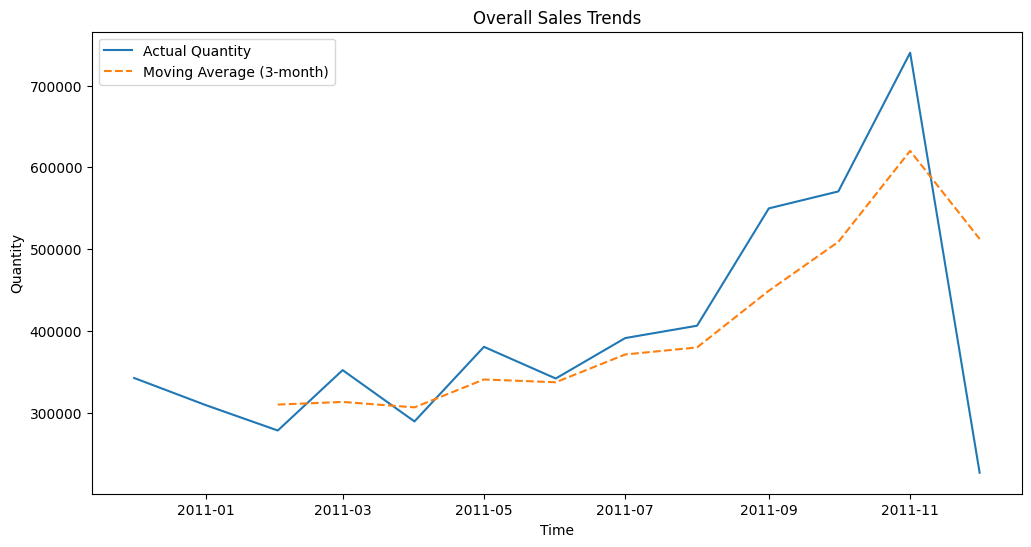

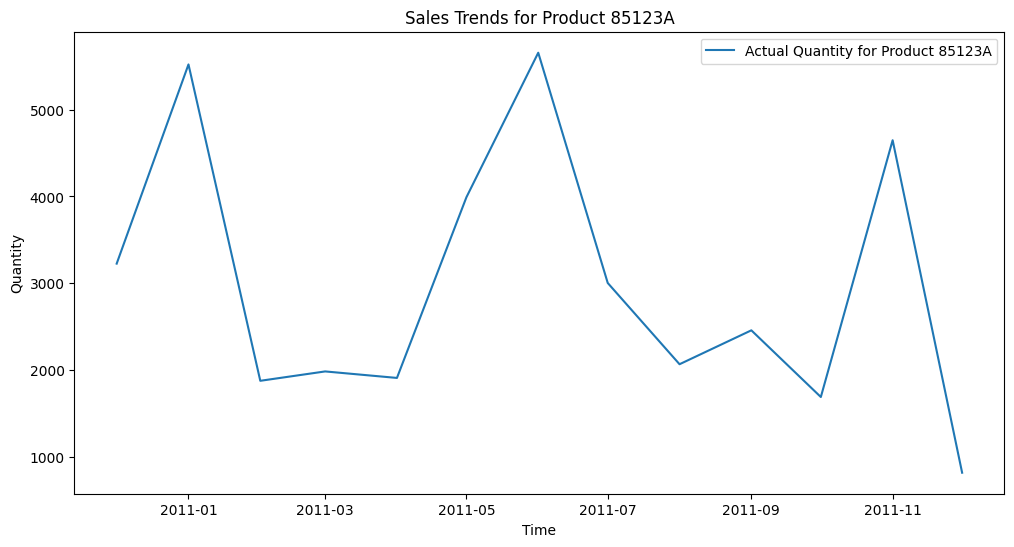

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Step 1: Read the CSV File
file_path = 'OnlineRetail.csv'  # Replace with your file path
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Step 2: Data Preparation
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')  # Extract month and year
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Step 3: Aggregate Data by Month for Overall Forecast
monthly_sales = df.groupby('MonthYear').agg({'Quantity': 'sum'}).reset_index()
monthly_sales['MonthYear'] = pd.to_datetime(monthly_sales['MonthYear'].astype(str))
monthly_sales['TimeID'] = monthly_sales.index  # Create a numerical time ID

# Step 4: Aggregate Data by Product for Product-Level Forecast
product_sales = df.groupby(['StockCode', 'MonthYear']).agg({'Quantity': 'sum'}).reset_index()
product_sales['MonthYear'] = pd.to_datetime(product_sales['MonthYear'].astype(str))
product_sales['TimeID'] = product_sales.groupby('StockCode').cumcount()  # Create a product-specific time ID

# Step 5: Moving Average
monthly_sales['Quantity_MA'] = monthly_sales['Quantity'].rolling(window=3).mean()

# Step 6: Train-Test Split for Overall Forecast
X_overall = monthly_sales[['TimeID']].values
y_overall = monthly_sales['Quantity'].values
X_train_overall, X_test_overall, y_train_overall, y_test_overall = train_test_split(X_overall, y_overall, test_size=0.2, random_state=42)

# Step 7: Train-Test Split for Product-Level Forecast
# Example for a specific product (you can loop over all products)
product_code = '85123A'  # Replace with a desired product code
product_df = product_sales[product_sales['StockCode'] == product_code]
X_product = product_df[['TimeID']].values
y_product = product_df['Quantity'].values
X_train_product, X_test_product, y_train_product, y_test_product = train_test_split(X_product, y_product, test_size=0.2, random_state=42)

# Step 8: Linear Regression Model for Overall Forecast
lin_model_overall = LinearRegression()
lin_model_overall.fit(X_train_overall, y_train_overall)
y_pred_lin_overall = lin_model_overall.predict(X_test_overall)

# Linear Regression Model for Product-Level Forecast
lin_model_product = LinearRegression()
lin_model_product.fit(X_train_product, y_train_product)
y_pred_lin_product = lin_model_product.predict(X_test_product)

# Step 9: K-Nearest Neighbors Model for Overall Forecast
knn_model_overall = KNeighborsRegressor(n_neighbors=3)
knn_model_overall.fit(X_train_overall, y_train_overall)
y_pred_knn_overall = knn_model_overall.predict(X_test_overall)

# K-Nearest Neighbors Model for Product-Level Forecast
knn_model_product = KNeighborsRegressor(n_neighbors=3)
knn_model_product.fit(X_train_product, y_train_product)
y_pred_knn_product = knn_model_product.predict(X_test_product)

# Step 10: Neural Network Model for Overall Forecast
nn_model_overall = Sequential()
nn_model_overall.add(Dense(64, input_dim=1, activation='relu'))
nn_model_overall.add(Dense(32, activation='relu'))
nn_model_overall.add(Dense(1, activation='linear'))

nn_model_overall.compile(loss='mean_squared_error', optimizer='adam')
nn_model_overall.fit(X_train_overall, y_train_overall, epochs=50, batch_size=5, verbose=1)
y_pred_nn_overall = nn_model_overall.predict(X_test_overall)

# Neural Network Model for Product-Level Forecast
nn_model_product = Sequential()
nn_model_product.add(Dense(64, input_dim=1, activation='relu'))
nn_model_product.add(Dense(32, activation='relu'))
nn_model_product.add(Dense(1, activation='linear'))

nn_model_product.compile(loss='mean_squared_error', optimizer='adam')
nn_model_product.fit(X_train_product, y_train_product, epochs=50, batch_size=5, verbose=1)
y_pred_nn_product = nn_model_product.predict(X_test_product)

# Step 11: Evaluate Models for Overall Forecast
mae_lin_overall = mean_absolute_error(y_test_overall, y_pred_lin_overall)
mse_lin_overall = mean_squared_error(y_test_overall, y_pred_lin_overall)
print(f"Overall Linear Regression MAE: {mae_lin_overall}, MSE: {mse_lin_overall}")

mae_knn_overall = mean_absolute_error(y_test_overall, y_pred_knn_overall)
mse_knn_overall = mean_squared_error(y_test_overall, y_pred_knn_overall)
print(f"Overall KNN MAE: {mae_knn_overall}, MSE: {mse_knn_overall}")

mae_nn_overall = mean_absolute_error(y_test_overall, y_pred_nn_overall)
mse_nn_overall = mean_squared_error(y_test_overall, y_pred_nn_overall)
print(f"Overall Neural Network MAE: {mae_nn_overall}, MSE: {mse_nn_overall}")

# Evaluate Models for Product-Level Forecast
mae_lin_product = mean_absolute_error(y_test_product, y_pred_lin_product)
mse_lin_product = mean_squared_error(y_test_product, y_pred_lin_product)
print(f"Product-Level Linear Regression MAE: {mae_lin_product}, MSE: {mse_lin_product}")

mae_knn_product = mean_absolute_error(y_test_product, y_pred_knn_product)
mse_knn_product = mean_squared_error(y_test_product, y_pred_knn_product)
print(f"Product-Level KNN MAE: {mae_knn_product}, MSE: {mse_knn_product}")

mae_nn_product = mean_absolute_error(y_test_product, y_pred_nn_product)
mse_nn_product = mean_squared_error(y_test_product, y_pred_nn_product)
print(f"Product-Level Neural Network MAE: {mae_nn_product}, MSE: {mse_nn_product}")

# Step 12: Plot Results for Overall Forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['MonthYear'], monthly_sales['Quantity'], label='Actual Quantity')
plt.plot(monthly_sales['MonthYear'], monthly_sales['Quantity_MA'], label='Moving Average (3-month)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Overall Sales Trends')
plt.legend()
plt.show()

# Plot for Product-Level Forecast
plt.figure(figsize=(12, 6))
plt.plot(product_df['MonthYear'], product_df['Quantity'], label=f'Actual Quantity for Product {product_code}')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title(f'Sales Trends for Product {product_code}')
plt.legend()
plt.show()


In [8]:
!pip install plotly

In [10]:
!pip install dash plotly pandas numpy keras
!python dashboard.py



python3: can't open file '/content/dashboard.py': [Errno 2] No such file or directory


In [11]:
    # Import required libraries
    import pandas as pd
    import numpy as np
    import dash
    from dash import dcc, html
    from dash.dependencies import Input, Output
    import plotly.graph_objs as go
    from sklearn.linear_model import LinearRegression
    from sklearn.neighbors import KNeighborsRegressor
    from keras.models import Sequential
    from keras.layers import Dense

    # Step 1: Load and Prepare Data
    file_path = 'OnlineRetail.csv'  # Replace with your file path
    df = pd.read_csv(file_path, encoding='ISO-8859-1')

    # Data Preparation
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')
    df['Revenue'] = df['Quantity'] * df['UnitPrice']

    # Aggregate Data
    monthly_sales = df.groupby('MonthYear').agg({'Revenue': 'sum', 'Quantity': 'sum'}).reset_index()
    monthly_sales['MonthYear'] = pd.to_datetime(monthly_sales['MonthYear'].astype(str))
    monthly_sales['TimeID'] = monthly_sales.index  # Create numerical time ID

    # Moving Average
    monthly_sales['Revenue_MA'] = monthly_sales['Revenue'].rolling(window=3).mean()

    # Linear Regression Model for Forecasting
    X = monthly_sales[['TimeID']].values
    y = monthly_sales['Revenue'].values
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    monthly_sales['Forecasted_Revenue_Lin'] = lin_model.predict(X)

    # Step 2: Create a Dash App
    app = dash.Dash(__name__)

    # Dashboard Layout
    app.layout = html.Div([
        html.H1('Sales Predictive Dashboard', style={'textAlign': 'center'}),

        # KPIs
        html.Div([
            html.Div([
                html.H3('Total Revenue'),
                html.P(f"${monthly_sales['Revenue'].sum():,.2f}"),
            ], className='four columns'),

            html.Div([
                html.H3('Forecasted Revenue (Next Year)'),
                html.P(f"${monthly_sales['Forecasted_Revenue_Lin'].sum():,.2f}"),
            ], className='four columns')
        ], className='row'),

        # Trends Plot
        dcc.Graph(id='revenue-trends',
                figure={
                    'data': [
                        go.Scatter(x=monthly_sales['MonthYear'], y=monthly_sales['Revenue'],
                                    mode='lines', name='Actual Revenue'),
                        go.Scatter(x=monthly_sales['MonthYear'], y=monthly_sales['Revenue_MA'],
                                    mode='lines', name='3-Month Moving Average'),
                        go.Scatter(x=monthly_sales['MonthYear'], y=monthly_sales['Forecasted_Revenue_Lin'],
                                    mode='lines', name='Forecasted Revenue')
                    ],
                    'layout': go.Layout(
                        title='Revenue Trends',
                        xaxis={'title': 'Month-Year'},
                        yaxis={'title': 'Revenue'},
                        hovermode='closest'
                    )
                }),

        # Insights and Recommendations
        html.Div([
            html.H2('Insights and Recommendations'),
            html.P('1. Focus on high-performing products based on sales trends.'),
            html.P('2. Adjust marketing strategies to boost sales in low-performing months.'),
            html.P('3. Use inventory management to optimize stock levels based on forecasted demand.')
        ]),
    ])

    # Run the Dashboard
    if __name__ == '__main__':
        app.run_server(debug=True)


/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<IPython.core.display.Javascript object>